# TabNet

In [1]:
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from transformers import *
from sklearn.model_selection import train_test_split

PyTorch version 1.7.1 available.
TensorFlow version 2.5.0 available.
/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [13]:
COLUMNS = ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'quote_av', 'trades', 
                   'tb_base_av', 'tb_quote_av', 'ignore']
URL = 'https://api.binance.com/api/v3/klines'
def get_data(start_date, end_date, symbol):
    data = []
    
    start = int(time.mktime(datetime.strptime(start_date + ' 00:00', '%Y-%m-%d %H:%M').timetuple())) * 1000
    end = int(time.mktime(datetime.strptime(end_date +' 23:59', '%Y-%m-%d %H:%M').timetuple())) * 1000
    params = {
        'symbol': symbol,
        'interval': '1h',
        'limit': 1000,
        'startTime': start,
        'endTime': end
    }
    
    while start < end:
        print(datetime.fromtimestamp(start // 1000))
        params['startTime'] = start
        result = requests.get(URL, params = params)
        js = result.json()
        if not js:
            break
        data.extend(js)  # result에 저장
        start = js[-1][0] + 60000  # 다음 step으로
    # 전처리
    if not data:  # 해당 기간에 데이터가 없는 경우
        print('해당 기간에 일치하는 데이터가 없습니다.')
        return -1
    df = pd.DataFrame(data)
    df.columns = COLUMNS
    df['Open_time'] = df.apply(lambda x:datetime.fromtimestamp(x['Open_time'] // 1000), axis=1)
    df = df.drop(columns = ['Close_time', 'ignore'])
    df['Symbol'] = symbol
    df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float
    df['trades'] = df['trades'].astype(int)
    return df

start_date = '2017-01-01'
end_date = '2021-12-31'
symbol = "BTCUSDT"
train_df = get_data(start_date, end_date, symbol)


2017-01-01 00:00:00
2017-09-28 02:01:00
2017-11-08 18:01:00
2017-12-20 10:01:00
2018-01-31 03:01:00
2018-03-15 03:01:00
2018-04-25 19:01:00
2018-06-06 11:01:00
2018-07-18 21:01:00
2018-08-29 13:01:00
2018-10-10 05:01:00
2018-11-21 07:01:00
2019-01-01 23:01:00
2019-02-12 15:01:00
2019-03-26 13:01:00
2019-05-07 05:01:00
2019-06-18 07:01:00
2019-07-29 23:01:00
2019-09-09 23:01:00
2019-10-21 15:01:00
2019-12-02 11:01:00
2020-01-13 03:01:00
2020-02-24 01:01:00
2020-04-05 18:01:00
2020-05-17 12:01:00
2020-06-28 07:01:00
2020-08-08 23:01:00
2020-09-19 15:01:00
2020-10-31 07:01:00
2020-12-12 00:01:00
2021-01-22 20:01:00
2021-03-05 13:01:00
2021-04-16 06:01:00
2021-05-28 03:01:00
2021-07-08 19:01:00
2021-08-19 15:01:00
2021-09-30 09:01:00
2021-11-11 01:01:00
2021-12-22 17:01:00
2021-12-31 23:01:00


In [15]:
train_df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171,35.160503,1.509525e+05,BTCUSDT
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102,21.448071,9.260828e+04,BTCUSDT
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36,4.802861,2.079532e+04,BTCUSDT
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25,2.602292,1.129135e+04,BTCUSDT
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28,0.814655,3.552747e+03,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...
38217,2021-12-31 19:00:00,46686.42,46688.68,45678.96,45728.28,3851.309020,1.776171e+08,87472,1691.645420,7.803749e+07,BTCUSDT
38218,2021-12-31 20:00:00,45728.28,46211.07,45678.00,45879.24,1831.412020,8.422142e+07,51300,997.723690,4.588270e+07,BTCUSDT
38219,2021-12-31 21:00:00,45886.66,46513.67,45766.85,46333.86,1734.695850,7.997065e+07,54579,972.440650,4.482430e+07,BTCUSDT
38220,2021-12-31 22:00:00,46333.87,46569.97,46232.36,46303.99,991.851420,4.600406e+07,36280,447.966050,2.077702e+07,BTCUSDT


In [17]:
train_df = train_df.dropna() 

train_df.shape

(38222, 11)

In [18]:
start_date = '2022-01-01'
end_date = '2022-02-23'
symbol = "BTCUSDT"
test_df = get_data(start_date, end_date, symbol)


2022-01-01 00:00:00
2022-02-11 15:01:00
2022-02-23 13:01:00


In [19]:
test_df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2022-01-01 00:00:00,46216.93,46731.39,46208.37,46656.13,1503.33095,6.987999e+07,38608,806.06536,3.746216e+07,BTCUSDT
1,2022-01-01 01:00:00,46656.14,46949.99,46574.06,46778.14,943.81539,4.412715e+07,31872,491.18067,2.296327e+07,BTCUSDT
2,2022-01-01 02:00:00,46778.14,46928.94,46721.96,46811.77,485.16860,2.272067e+07,24364,206.35113,9.662607e+06,BTCUSDT
3,2022-01-01 03:00:00,46811.77,46916.63,46760.12,46813.20,562.88971,2.636326e+07,19882,248.28212,1.162938e+07,BTCUSDT
4,2022-01-01 04:00:00,46813.21,46887.33,46591.23,46711.05,861.88389,4.027204e+07,23357,397.53563,1.857540e+07,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...
1281,2022-02-23 09:00:00,38673.02,38990.00,38600.01,38876.90,2085.38386,8.099305e+07,46811,1085.34474,4.215269e+07,BTCUSDT
1282,2022-02-23 10:00:00,38876.89,38956.64,38759.31,38866.27,1392.93540,5.414059e+07,34999,707.04677,2.748227e+07,BTCUSDT
1283,2022-02-23 11:00:00,38866.28,39125.47,38734.64,38782.91,1833.75028,7.130252e+07,41770,950.84726,3.697726e+07,BTCUSDT
1284,2022-02-23 12:00:00,38782.91,39100.00,38749.36,39016.39,1490.29190,5.798004e+07,38441,824.76875,3.208963e+07,BTCUSDT


In [27]:
train_df.to_csv("BTC_1hr_train.csv",index=False)

In [28]:
test_df.to_csv("BTC_1hr_test.csv",index=False)

# Preprocess Data for training

In [2]:
train_df = pd.read_csv("BTC_1hr_train.csv") 

test_df = pd.read_csv("BTC_1hr_test.csv") 

fear_greed = pd.read_csv("fear_greed_2022_02_23.csv") 

In [3]:
fear_greed = fear_greed[['날짜', '공포지수']] 

fear_greed.head()

,날짜,공포지수
0,2022/02/23,36.91
1,2022/02/22,33.21
2,2022/02/21,26.89
3,2022/02/20,32.28
4,2022/02/19,38.83


In [4]:
dates = fear_greed['날짜'].values 
years, months, days = [], [], [] 
for date in dates:
    splitted = date.split('/') 
    year = int(splitted[0]) 
    month = int(splitted[1]) 
    day = int(splitted[2]) 
    years.append(year) 
    months.append(month) 
    days.append(day) 
    
fear_greed['Days'] = days 
fear_greed['Months'] = months 
fear_greed['Years'] = years 

fear_greed.head()

,날짜,공포지수,Days,Months,Years
0,2022/02/23,36.91,23,2,2022
1,2022/02/22,33.21,22,2,2022
2,2022/02/21,26.89,21,2,2022
3,2022/02/20,32.28,20,2,2022
4,2022/02/19,38.83,19,2,2022


In [5]:
def ROC(df, n): 
    M = df.diff(n-1) 
    N = df.shift(n-1) 
    ROC = pd.Series(((M/N)*100), name = "ROC_" + str(n)) 
    return ROC 

def RSI(series, period): 
    delta = series.diff().dropna() 
    u = delta * 0 
    d = u.copy() 
    u[delta > 0] = delta[delta > 0] 
    d[delta < 0] = -delta[delta < 0] 
    u[u.index[period-1]] = np.mean(u[:period]) # first value is sum of avg gains 
    u = u.drop(u.index[:(period-1)]) 
    d[d.index[period-1]] = np.mean(d[:period]) # first value is sum of avg losses 
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean() 
    return 100 - 100 / (1+rs) 

def MOM(df, n): 
    MOM = pd.Series(df.diff(n), name="Momentum_" + str(n)) 
    return MOM 

# stochastic oscillator %K
def STOK(close, low, high, n): 
    stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return stok 

# stochatic oscillator %D
def STOD(close, low, high, n):
    stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    stod = stok.rolling(3).mean() 
    return stod 

def feature_engineering(df): 
    print("===== Feature Engineering =====")
    windows = [5, 10, 14, 20, 30, 60, 120, 200] # from short term to long term 
    
    # columns to drop 
    drop_cols = ["Open_time", 
                 "Open", 
                 "High", 
                 "Low", 
                 "Close", 
                 "Volume",
                 "quote_av", 
                 "trades",
                 "tb_base_av",
                 "tb_quote_av", 
                 "Symbol"] 
    
    for window in windows: 
        df['BTC_Open_ma{}'.format(window)] = df['Open'].rolling(window).mean() 
        df['BTC_Open_ma{}_ratio'.format(window)] = (df['Open'] - df['BTC_Open_ma{}'.format(window)]) / df['BTC_Open_ma{}'.format(window)]

        df['BTC_High_ma{}'.format(window)] = df['High'].rolling(window).mean()
        df['BTC_High_ma{}_ratio'.format(window)] = (df['High'] - df['BTC_High_ma{}'.format(window)]) / df['BTC_High_ma{}'.format(window)]

        df['BTC_Low_ma{}'.format(window)] = df['Low'].rolling(window).mean() 
        df['BTC_Low_ma{}_ratio'.format(window)] = (df['Low'] - df['BTC_Low_ma{}'.format(window)]) / df['BTC_Low_ma{}'.format(window)]
        
        df['BTC_Close_ma{}'.format(window)] = df['Close'].rolling(window).mean() 
        df['BTC_Close_ma{}_ratio'.format(window)] = (df['Close'] - df['BTC_Close_ma{}'.format(window)]) / df['BTC_Close_ma{}'.format(window)]

        df['BTC_Volume_ma{}'.format(window)] = df['Volume'].rolling(window).mean() 
        df['BTC_Volume_ma{}_ratio'.format(window)] = (df['Volume'] - df['BTC_Volume_ma{}'.format(window)]) / df['BTC_Volume_ma{}'.format(window)]
        
        df['BTC_quote_av_ma{}'.format(window)] = df['quote_av'].rolling(window).mean() 
        df['BTC_quote_av_ma{}_ratio'.format(window)] = (df['quote_av'] - df['BTC_quote_av_ma{}'.format(window)]) / df['BTC_quote_av_ma{}'.format(window)]
        
        df['BTC_trades_ma{}'.format(window)] = df['trades'].rolling(window).mean() 
        df['BTC_trades_ma{}_ratio'.format(window)] = (df['trades'] - df['BTC_trades_ma{}'.format(window)]) / df['BTC_trades_ma{}'.format(window)]
        
        df['BTC_tb_base_av_ma{}'.format(window)] = df['tb_base_av'].rolling(window).mean() 
        df['BTC_tb_base_av_ma{}_ratio'.format(window)] = (df['tb_base_av'] - df['BTC_tb_base_av_ma{}'.format(window)]) / df['BTC_tb_base_av_ma{}'.format(window)]
        
        df['BTC_tb_quote_av_ma{}'.format(window)] = df['tb_quote_av'].rolling(window).mean() 
        df['BTC_tb_quote_av_ma{}_ratio'.format(window)] = (df['tb_quote_av'] - df['BTC_tb_quote_av_ma{}'.format(window)]) / df['BTC_tb_quote_av_ma{}'.format(window)]
        
        df['ROC{}'.format(window)] = ROC(df['Open'], window)
        
        df['RSI{}'.format(window)] = RSI(df['Open'], window)
        
        df['MOM{}'.format(window)] = MOM(df['Open'], window) 
        
        df['%K{}'.format(window)] = STOK(df['Close'], df['Low'], df['High'], window)
        df['%D{}'.format(window)] = STOD(df['Close'], df['Low'], df['High'], window)
        
        drop_cols.append('BTC_Open_ma{}'.format(window))
        drop_cols.append('BTC_High_ma{}'.format(window))
        drop_cols.append('BTC_Low_ma{}'.format(window))
        drop_cols.append('BTC_Close_ma{}'.format(window)) 
        drop_cols.append('BTC_Volume_ma{}'.format(window)) 
        drop_cols.append('BTC_quote_av_ma{}'.format(window))
        drop_cols.append('BTC_trades_ma{}'.format(window))
        drop_cols.append('BTC_tb_base_av_ma{}'.format(window))
        drop_cols.append('BTC_tb_quote_av_ma{}'.format(window))
        
    # extract date and time information 
    print("Extracting Date and Time Information...")
    hours, days, months, years = [], [], [], []  
    future_hours, future_days, future_months = [], [], [] 
    for dt in tqdm(df['Open_time']):
        hour = pd.to_datetime(dt).hour 
        day = pd.to_datetime(dt).day 
        month = pd.to_datetime(dt).month  
        year = pd.to_datetime(dt).year 
        hours.append(hour) 
        days.append(day) 
        months.append(month)  
        years.append(year)
        
        forecast_dt = pd.to_datetime(dt) + timedelta(hours=1) 
        future_hour = pd.to_datetime(forecast_dt).hour 
        future_day = pd.to_datetime(forecast_dt).day 
        future_month = pd.to_datetime(forecast_dt).month 
        future_hours.append(future_hour) 
        future_days.append(future_day) 
        future_months.append(future_month)
        
    df['Hours'] = hours 
    df['Days'] = days 
    df['Months'] = months 
    df['Years'] = years  
    
    df['Future_Hours'] = future_hours
    df['Future_Days'] = future_days 
    df['Future_Months'] = future_months
    
    print("Creating Target Column...") 
    targets = [None]
    open_values = df['Open'].values 
    for i in range(1, open_values.shape[0]):
        ret = (open_values[i] - open_values[i-1]) / open_values[i-1] * 100 
        if ret >= 1.0:
            targets.append(0) # long 
        elif ret <= -1.0:
            targets.append(1) # short 
        else:
            targets.append(2) # do nothing 
    df['Target'] = targets
    
        
    
    df = df.dropna() 
    # join fear greed index with df 
    df = df.merge(fear_greed, how='inner', left_on=['Days','Months','Years'], right_on=['Days','Months','Years'])
    
    
    
    drop_cols.append('Years') 
    drop_cols.append('날짜') 
    df = df.rename(columns={'공포지수':'Fear_Greed_Index'}) 
    df = df.drop(columns={drop_cols[i] for i in range(len(drop_cols))})
    return df


In [6]:
processed_train = feature_engineering(train_df)

===== Feature Engineering =====
Extracting Date and Time Information...


100%|██████████| 38222/38222 [00:23<00:00, 1650.74it/s]


Creating Target Column...


In [8]:
processed_train.head() 

,BTC_Open_ma5_ratio,BTC_High_ma5_ratio,BTC_Low_ma5_ratio,BTC_Close_ma5_ratio,BTC_Volume_ma5_ratio,BTC_quote_av_ma5_ratio,BTC_trades_ma5_ratio,BTC_tb_base_av_ma5_ratio,BTC_tb_quote_av_ma5_ratio,ROC5,...,%K200,%D200,Hours,Days,Months,Future_Hours,Future_Days,Future_Months,Target,Fear_Greed_Index
0,0.007842,0.017503,0.010278,0.008660,0.403741,0.409748,0.708562,0.824174,0.831485,1.906163,...,75.765273,75.186343,0,8,10,1,8,10,2.0,55.78
1,0.009489,0.006468,0.008016,0.009009,-0.063745,-0.060823,-0.107997,-0.778443,-0.777619,2.468443,...,82.276063,75.981648,1,8,10,2,8,10,2.0,55.78
2,0.008828,-0.002128,0.003764,-0.000407,-0.348456,-0.347972,0.177334,-0.545114,-0.544360,2.296519,...,76.466502,78.169279,2,8,10,3,8,10,2.0,55.78
3,-0.000251,-0.002338,0.003651,0.001090,0.002688,0.004078,0.178103,0.072607,0.075098,-0.152018,...,77.172267,78.638277,3,8,10,4,8,10,2.0,55.78
4,0.004500,-0.002717,0.000234,-0.002992,-0.401288,-0.402381,-0.440659,-0.589132,-0.590297,1.197740,...,74.082040,75.906936,4,8,10,5,8,10,2.0,55.78


In [9]:
processed_test = feature_engineering(test_df) 

===== Feature Engineering =====
Extracting Date and Time Information...


100%|██████████| 1286/1286 [00:00<00:00, 1677.67it/s]

Creating Target Column...


In [10]:
processed_test.head()

,BTC_Open_ma5_ratio,BTC_High_ma5_ratio,BTC_Low_ma5_ratio,BTC_Close_ma5_ratio,BTC_Volume_ma5_ratio,BTC_quote_av_ma5_ratio,BTC_trades_ma5_ratio,BTC_tb_base_av_ma5_ratio,BTC_tb_quote_av_ma5_ratio,ROC5,...,%K200,%D200,Hours,Days,Months,Future_Hours,Future_Days,Future_Months,Target,Fear_Greed_Index
0,-0.004034,-0.003993,-0.004367,-0.005070,0.330785,0.325823,0.143445,0.365949,0.361019,-0.980860,...,13.473227,15.423466,9,9,1,10,9,1,2.0,40.02
1,-0.005070,-0.003149,-0.004356,-0.001262,0.057771,0.054231,0.055382,0.032157,0.028586,-0.612677,...,15.271732,14.770018,10,9,1,11,9,1,2.0,40.02
2,-0.001261,0.002895,0.001421,0.003922,0.102687,0.106246,0.024310,0.259915,0.263753,-0.546693,...,18.114835,15.619931,11,9,1,12,9,1,2.0,40.02
3,0.003922,0.001233,0.002520,0.001482,-0.249650,-0.248339,-0.134395,-0.346480,-0.345427,0.158214,...,16.637468,16.674678,12,9,1,13,9,1,2.0,40.02
4,0.001482,0.000799,-0.001495,-0.004223,0.206601,0.206151,0.057410,0.063595,0.063137,0.192768,...,12.938977,15.897094,13,9,1,14,9,1,2.0,40.02


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Target', ylabel='count'>

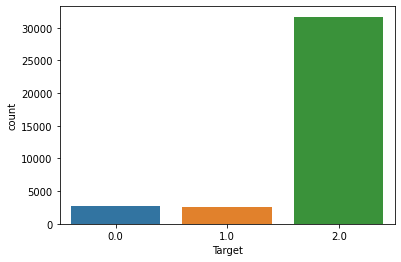

In [11]:
# distribution of labels 

sns.countplot(processed_train['Target'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Target', ylabel='count'>

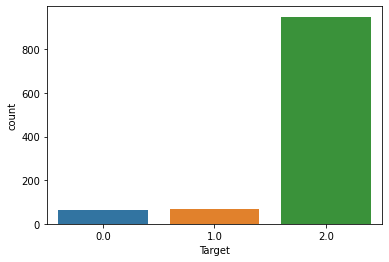

In [12]:
sns.countplot(processed_test['Target'])

# Train TabNet

In [68]:
features = [] 
for col in processed_train.columns:
    if col != 'Target':
        features.append(col) 
        
X = processed_train[features].values
Y = processed_train['Target'].values

Y = Y.reshape((-1,1))

X.shape, Y.shape

((36985, 119), (36985, 1))

In [69]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
clf = TabNetMultiTaskClassifier()

X_train, X_valid, Y_train, y_valid = train_test_split(X, Y, test_size=0.1, stratify=Y)

clf.fit(
  X_train, Y_train,
  eval_set=[(X_valid, y_valid)], 
  eval_metric=['accuracy'], 
  patience = 20, 
  max_epochs = 240
)

Device used : cuda
epoch 0  | loss: 0.6095  | val_0_accuracy: 0.85428 |  0:00:02s
epoch 1  | loss: 0.42753 | val_0_accuracy: 0.85888 |  0:00:05s
epoch 2  | loss: 0.34889 | val_0_accuracy: 0.85699 |  0:00:07s
epoch 3  | loss: 0.32375 | val_0_accuracy: 0.85699 |  0:00:10s
epoch 4  | loss: 0.3081  | val_0_accuracy: 0.85672 |  0:00:12s
epoch 5  | loss: 0.3048  | val_0_accuracy: 0.85699 |  0:00:15s
epoch 6  | loss: 0.30169 | val_0_accuracy: 0.85699 |  0:00:17s
epoch 7  | loss: 0.29594 | val_0_accuracy: 0.85699 |  0:00:20s
epoch 8  | loss: 0.29303 | val_0_accuracy: 0.85699 |  0:00:23s
epoch 9  | loss: 0.29054 | val_0_accuracy: 0.85699 |  0:00:25s
epoch 10 | loss: 0.28968 | val_0_accuracy: 0.85699 |  0:00:28s
epoch 11 | loss: 0.28938 | val_0_accuracy: 0.85699 |  0:00:30s
epoch 12 | loss: 0.28892 | val_0_accuracy: 0.85699 |  0:00:33s
epoch 13 | loss: 0.28924 | val_0_accuracy: 0.8578  |  0:00:35s
epoch 14 | loss: 0.28453 | val_0_accuracy: 0.85726 |  0:00:38s
epoch 15 | loss: 0.2847  | val_0_acc

In [95]:
x_test = processed_test[features].values 
y_test = processed_test['Target'].values 

preds = clf.predict(x_test)[0]

In [124]:
preds = preds.astype(np.float)
acc = 0 
total = 0 
for i in range(len(preds)):
    if y_test[i] != 2:
        total += 1 
        if preds[i] == y_test[i]:
            acc += 1 
acc / total * 100 

59.25925925925925

In [127]:
total

135

In [125]:
preds = preds.astype(np.float)
acc = 0 
for i in range(len(preds)):
    if preds[i] == y_test[i]:
        acc += 1 

acc / len(preds) * 100 

93.36405529953917

In [126]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("precision = {}".format(precision_score(y_test, preds, average='macro'))) 
print("recall = {}".format(recall_score(y_test, preds, average='macro')))
print("f1 = {}".format(f1_score(y_test, preds, average='macro')))

precision = 0.8680935086098939
recall = 0.7233391170233275
f1 = 0.7806580259222332
